In [76]:
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import learning_curve
# KNN Model
from sklearn.neighbors import KNeighborsClassifier
from collections import Counter

In [77]:
import pickle 

# Đọc dữ liệu bệnh tim, phân loại nhị phân
with open('preprocessing/heart/X.pkl', 'rb') as f:
    X = pickle.load(f)
with open('preprocessing/heart/y.pkl', 'rb') as f:
    y = pickle.load(f)

# with open('preprocessing/cirrhosis/X.pkl', 'br') as f:
#     X = pickle.load(f)

# with open('preprocessing/cirrhosis/y.pkl', 'rb') as f:
#     y = pickle.load(f)

print('So luong du lieu: ', len(X))
print('So luong nhan: ', len(y))
X[0:5]

So luong du lieu:  1025
So luong nhan:  1025


,age,trestbps,chol,thalach,oldpeak,sex_0,sex_1,cp_0,cp_1,cp_2,...,slope_2,ca_0,ca_1,ca_2,ca_3,ca_4,thal_0,thal_1,thal_2,thal_3
0,-0.268437,-0.377636,-0.659332,0.821321,-0.060888,0,1,1,0,0,...,1,0,0,1,0,0,0,0,0,1
1,-0.158157,0.479107,-0.833861,0.255968,1.727137,0,1,1,0,0,...,0,1,0,0,0,0,0,0,0,1
2,1.716595,0.764688,-1.396233,-1.048692,1.301417,0,1,1,0,0,...,0,1,0,0,0,0,0,0,0,1
3,0.724079,0.936037,-0.833861,0.516900,-0.912329,0,1,1,0,0,...,1,0,1,0,0,0,0,0,0,1
4,0.834359,0.364875,0.930822,-1.874977,0.705408,1,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0


In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=10)
X_train

,age,trestbps,chol,thalach,oldpeak,sex_0,sex_1,cp_0,cp_1,cp_2,...,slope_2,ca_0,ca_1,ca_2,ca_3,ca_4,thal_0,thal_1,thal_2,thal_3
339,0.613800,-0.092055,0.135745,-0.222407,0.279688,0,1,1,0,0,...,1,0,1,0,0,0,0,0,0,1
469,1.385757,1.621431,0.775685,-1.787999,0.364832,0,1,1,0,0,...,0,0,0,0,1,0,0,0,1,0
472,0.393241,-0.092055,-0.950214,-0.787760,-0.401465,1,0,1,0,0,...,0,1,0,0,0,0,0,0,1,0
307,-1.150673,-0.663216,-0.504195,0.908298,-0.912329,0,1,0,1,0,...,1,1,0,0,0,0,0,0,1,0
783,0.172682,-0.663216,-0.116353,0.864809,-0.912329,0,1,0,1,0,...,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47,1.275477,2.649522,-0.349058,0.690855,-0.060888,1,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
108,-1.591791,1.164502,-0.446019,1.386673,-0.912329,0,1,1,0,0,...,1,1,0,0,0,0,0,0,0,1
38,1.054918,-0.206287,0.329666,-1.918465,-0.742041,0,1,1,0,0,...,0,0,1,0,0,0,0,0,0,1
660,0.724079,0.364875,-1.551370,-1.048692,2.152857,0,1,1,0,0,...,0,0,1,0,0,0,0,0,1,0


In [79]:
def cross_validation(estimator):
    _, train_scores, test_scores = learning_curve(estimator, X_train, y_train, cv=10, n_jobs=-1, train_sizes=[1.0, ], scoring="accuracy")
    test_scores = test_scores[0]
    mean, std = test_scores.mean(), test_scores.std()
    return mean, std

def plot(title, xlabel, X, Y, error, ylabel = "Accuracy"):
    plt.xlabel(xlabel)
    plt.title(title)
    plt.grid()
    plt.ylabel(ylabel)
    plt.errorbar(X, Y, error, linestyle='None', marker='o')

In [80]:
class KNN:
    def __init__(self, top_k=5):
        self.top_k = top_k
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    @staticmethod
    def distance(x1, x2):
        return np.linalg.norm(x1 - x2)

    def predict_batch(self, X):
        y_pred = [self.predict(x) for x in X]
        return y_pred

    def predict(self, x):
        # Compute distance to all points in train set
        distances = [self.distance(x, x_train) for x_train in self.X_train]
        # Sort the distance with index
        top_idx = np.argsort(distances)[:self.top_k]
        # Get top K label
        k_nearests = self.y_train[top_idx]
        # Predict the label
        label = Counter(k_nearests).most_common(1)[0][0]
        
        return label

100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


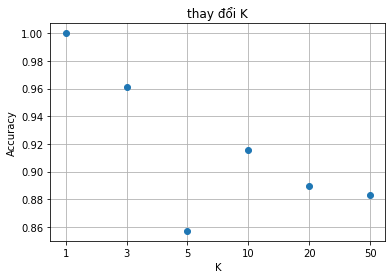

In [81]:
title = "thay đổi K"
xlabel = "K"
X = []
Y = []
error = []

for k in tqdm([1, 3, 5, 10, 20, 50]):
    # Load model
    model = KNN(top_k = k)
    model.fit(np.array(X_train), np.array(y_train))

    # Sample predict model
    y_pred = model.predict_batch(np.array(X_test))

    # Caculate accuracy score
    acc = accuracy_score(y_pred, np.array(y_test))

    X.append(str(k))
    Y.append(acc)
    error.append(0)

# lưu kết quả ra file ảnh
plot(title, xlabel, X, Y, error)
# plt.savefig('images/KNN_change_K.png', bbox_inches='tight')
plt.show()

In [88]:
# Test mô hình với K=5, cho độ chính xác cao nhất
model = KNN(top_k = 1)

model.fit(np.array(X_train), np.array(y_train))

# Sample predict model
y_pred = model.predict_batch(np.array(X_test))

# Caculate accuracy score
acc = accuracy_score(y_pred, np.array(y_test))

acc

1.0

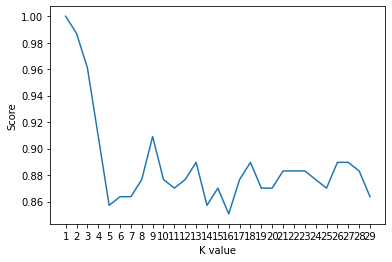

Maximum KNN Score is 100.00%


In [83]:
# try ro find best k value với thư viện KNeighborsClassifier
scoreList = []
for i in range(1,30):
    knn2 = KNeighborsClassifier(n_neighbors = i)  # n_neighbors means k
    knn2.fit(X_train, y_train)
    scoreList.append(knn2.score(X_test, y_test))
    
plt.plot(range(1,30), scoreList)
plt.xticks(np.arange(1,30,1))
plt.xlabel("K value")
plt.ylabel("Score")
plt.show()

acc = max(scoreList)*100
print("Maximum KNN Score is {:.2f}%".format(acc))

KNN: 1.0


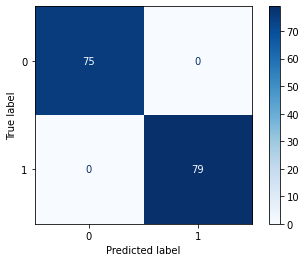

<Figure size 864x864 with 0 Axes>

In [87]:
# Test với bộ tham số tốt nhất
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

print(f'KNN: {accuracy_score(y_test, knn.predict(X_test))}')
# Hiển thị confusion matrix

plot_confusion_matrix(knn, X_test, y_test, cmap=plt.cm.Blues)  
plt.figure(figsize = (12, 12))
plt.show()

In [85]:
# Generating classification report
from sklearn.metrics import classification_report
y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.83      0.86        75
           1       0.85      0.91      0.88        79

    accuracy                           0.87       154
   macro avg       0.87      0.87      0.87       154
weighted avg       0.87      0.87      0.87       154



In [89]:
from sklearn.metrics import precision_score, recall_score
recall_s = recall_score(y_test, knn.predict(X_test), average=None)
print('Tỉ lệ dự đoán đúng người bị bệnh là ', recall_s[1])
print('Tỉ lệ dự đoán đúng người không bị bệnh là', recall_s[0])

Tỉ lệ dự đoán đúng người bị bệnh là  1.0
Tỉ lệ dự đoán đúng người không bị bệnh là 1.0
